<a href="https://colab.research.google.com/github/bbchen33/Flow_Cytometry/blob/master/Flow_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing Flow Cytometry data with FlowCal package

In [ ]:
!pip install --quiet FlowCal # install the package

In [ ]:
import FlowCal

Loading the samples with FlowCal 
1. "killed": heat-killed cells as the control
2. "tp0": cells from time point 0, mostly alive.

In [ ]:
killed = FlowCal.io.FCSData('Time pt 0h_killed E.fcs')
killed = FlowCal.transform.to_rfi(killed)
tp0 = FlowCal.io.FCSData('Time pt 0h_Tube_001.fcs')
tp0 = FlowCal.transform.to_rfi(tp0)

A quick function to plot the flow scatterplot showing FSC and SSC axes. 

In [ ]:
def flow_scatter(sample_name):
  FlowCal.plot.density2d(sample_name, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.xlim((6*10**3,10**6))
  plt.ylim((6*10**3,10**6))
  plt.title(sample_name)
  plt.show()

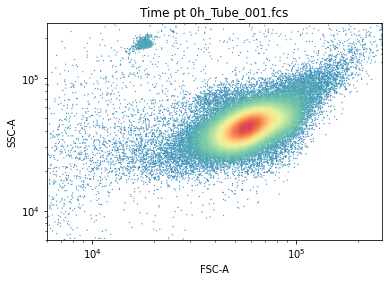

In [ ]:
flow_scatter(tp0)

A function to gate on Alexa 405-positive beads: 
1. Gate the beads based on size
2. Filter the gated beads based on Alexa 405 signal (positive)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
def gate_beads(sample_name, x = 4.2, y = 5.4): # x and y are the center of where the beads are expected
  beads = FlowCal.gate.ellipse(sample_name, channels = ['FSC-A', 'SSC-A'],
                             log = True,
                             center = (4.2,5.4), a = 0.2, b = 0.2)
  beads_pos = FlowCal.gate.high_low(beads, channels='Alexa Fluor 405-A', 
                               high=10**5, low=1.5*10**4)
  plt.figure(figsize=(6,12))
  plt.subplots_adjust(hspace = 0.4)
  plt.subplot(311)
  FlowCal.plot.density2d(beads, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.title('Before filtering by Alexa 405 signal')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))
  plt.subplot(312)
  FlowCal.plot.density2d(beads_pos, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))
  plt.title('After filtering by positive-Alexa 405 signal')

  plt.subplot(313)
  FlowCal.plot.hist1d(beads_pos, channel = 'Alexa Fluor 405-A')
  plt.title('After filtering by Alexa 405 signal - Histogram')

  print('Number of beads: ', beads_pos.shape[0])
  return beads_pos

Number of beads:  1262


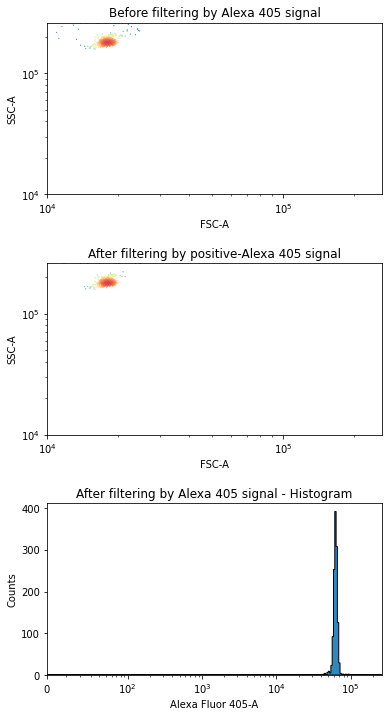

In [ ]:
beads = gate_beads(tp0)

Gating live cells.
1. First gate the cells based on FSC and SSC
2. Then filter out dead cells if Zombie Red positive

In [ ]:
def gate_live_cells(samples):
  live_cells = FlowCal.gate.ellipse(samples, channels = ['FSC-A','SSC-A'], 
                                    log = True, center = (5, 4.7),
                                    a = 0.6, b = 0.4, theta = 50/180.*np.pi)
  
  
  zom_neg = FlowCal.gate.high_low(live_cells, channels='PE-Texas Red-A', 
                               high=6*10**3, low=100)
  plt.figure(figsize=(6,8))
  plt.subplots_adjust(hspace = 0.4)
  
  plt.subplot(211)
  FlowCal.plot.density2d(zom_neg, channels = ['FSC-A','SSC-A'], mode = 'scatter')
  plt.title('Gated live cells')
  plt.xlim((10**4,10**6))
  plt.ylim((10**4,10**6))

  plt.subplot(212)
  FlowCal.plot.hist1d(zom_neg, channel = 'PE-Texas Red-A')
  plt.title('Zombie Red signal from gated cells')
  print('number of live cells: ', zom_neg.shape[0])
  return zom_neg


number of live cells:  85022


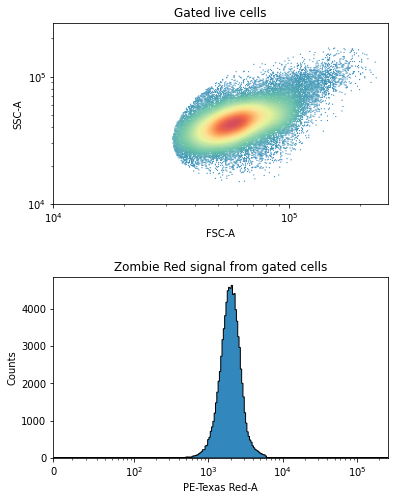

In [ ]:
live_tp0 = gate_live_cells(tp0)

number of live cells:  14


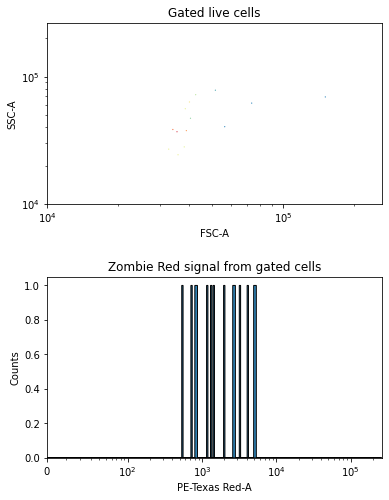

In [ ]:
live_killed = gate_live_cells(killed) # only 14 live cells in the killed sample